In [1]:
import matplotlib.pyplot as plt
import cv2
import os
from skimage.morphology import watershed
from scipy import ndimage as ndi
import numpy as np
from shapely.geometry import Polygon
from typing import Union
import geopandas as gpd

In [2]:
def show_images(images, cols = 2, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [24]:
def IoU(polygon: Polygon, other_polys: Union[Polygon, gpd.GeoDataFrame]):
    """Calculates Intersection over Union
    """
    intersection_areas = other_polys.intersection(polygon).area
    union_areas = polygon.area + other_polys.area - intersection_areas
    return intersection_areas / union_areas


def filter_prediction(pred_mask: np.ndarray):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
    opening = cv2.morphologyEx(pred_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    return closing


def fit_shapes(pred_mask: np.ndarray, use_shape_thesh=0.7):
    contours, _ = cv2.findContours(pred_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    fitted_image = np.zeros(pred_mask.shape)
    for cont in contours:
        _, trig_vertices = cv2.minEnclosingTriangle(cont)
        rect_params = cv2.minAreaRect(cont)
        try:
            trig_vertices = trig_vertices.squeeze().astype(np.int32)
            rect_vertices = cv2.boxPoints(rect_params)
            rect_vertices = np.int32(rect_vertices)

            cont_poly = Polygon(cont.squeeze())
            rect_poly = Polygon(rect_vertices)
            trig_poly = Polygon(trig_vertices)

            cont_poly = cont_poly.buffer(0)
            rect_poly = rect_poly.buffer(0)
            trig_poly = trig_poly.buffer(0)
        
            rect_score = IoU(cont_poly, rect_poly)
            trig_score = IoU(cont_poly, trig_poly)
        except:
            continue

        use_shape = (trig_score > use_shape_thesh) or (rect_score > use_shape_thesh)
        if use_shape:
            if rect_score > trig_score:
                cv2.drawContours(fitted_image, [rect_vertices], -1, (255,0,0), -1)        
            else:
                cv2.drawContours(fitted_image, [trig_vertices], -1, (255,0,0), -1)
        else:
            cv2.drawContours(fitted_image, [cont.squeeze()], -1, (255,0,0), -1)
    return fitted_image


def postprocess(pred_mask: np.ndarray, threshold=0.5):
    pred_mask = pred_mask > threshold
#     pred_mask = filter_prediction(pred_mask)
    if pred_mask.sum() != 0:
        pred_mask = fit_shapes(pred_mask)
    return pred_mask

In [28]:
GT_PATH = "/mnt/d/work/data/agrivision/val/labels/planter_skip"
PRED_PATH = "/mnt/d/work/artifacts/agrivision/misha/best_raw/predictions/planter_skip"
IMG_PATH = "/mnt/d/work/data/agrivision/val/images/rgb"
OUT_PATH = "/mnt/d/work/artifacts/agrivision/misha/best_processed/predictions/planter_skip"
os.makedirs(OUT_PATH)

In [18]:
pred_mask_names = os.listdir(PRED_PATH)
filename = pred_mask_names[16]
pred_mask_names

['18X67NLZ2_1219-1091-1731-1603.jpg',
 '18X67NLZ2_1219-1603-1731-2115.jpg',
 '18X67NLZ2_1219-579-1731-1091.jpg',
 '18X67NLZ2_707-1603-1219-2115.jpg',
 '1J7JL2PDK_1130-1579-1642-2091.jpg',
 '1J7JL2PDK_1211-1863-1723-2375.jpg',
 '1J7JL2PDK_2086-2862-2598-3374.jpg',
 '1J7JL2PDK_2131-4201-2643-4713.jpg',
 '1J7JL2PDK_2131-4713-2643-5225.jpg',
 '1J7JL2PDK_2229-3941-2741-4453.jpg',
 '1J7JL2PDK_2244-5103-2756-5615.jpg',
 '1J7JL2PDK_2303-3001-2815-3513.jpg',
 '1J7JL2PDK_2312-2249-2824-2761.jpg',
 '1LNFVP1VD_2044-1305-2556-1817.jpg',
 '1LNFVP1VD_2556-1305-3068-1817.jpg',
 '1LNFVP1VD_3068-1305-3580-1817.jpg',
 '1LNFVP1VD_3523-1714-4035-2226.jpg',
 '1LNFVP1VD_3714-1512-4226-2024.jpg',
 '1LNFVP1VD_4035-1714-4547-2226.jpg',
 '1LNFVP1VD_4035-2226-4547-2738.jpg',
 '1LNFVP1VD_4397-1936-4909-2448.jpg',
 '1LNFVP1VD_4547-2226-5059-2738.jpg',
 '1LNFVP1VD_4952-2136-5464-2648.jpg',
 '1LNFVP1VD_5571-2226-6083-2738.jpg',
 '26G8P9NJF_1261-6444-1773-6956.jpg',
 '26G8P9NJF_1261-6956-1773-7468.jpg',
 '26G8P9NJF_12

In [19]:
img = cv2.imread(os.path.join(IMG_PATH, filename), cv2.IMREAD_UNCHANGED)
pred_mask = cv2.imread(os.path.join(PRED_PATH, filename), cv2.IMREAD_UNCHANGED)
pred_mask = pred_mask/255
gt_mask = cv2.imread(os.path.join(GT_PATH, filename.replace('.jpg','.png')), cv2.IMREAD_UNCHANGED)

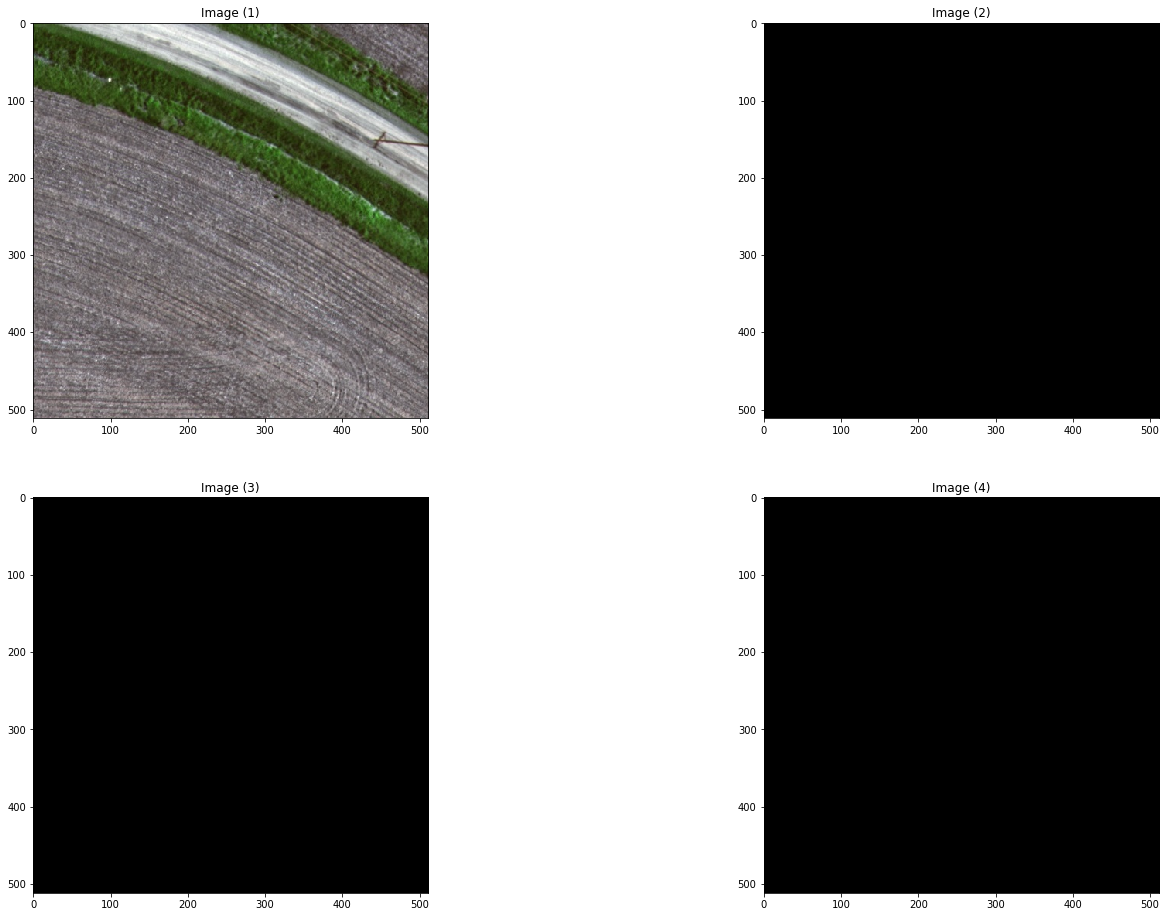

In [20]:
show_images([img, pred_mask, gt_mask, postprocess(pred_mask)])

In [29]:
for name in pred_mask_names:
    img = cv2.imread(os.path.join(IMG_PATH, name), cv2.IMREAD_UNCHANGED)
    pred_mask = cv2.imread(os.path.join(PRED_PATH, name), cv2.IMREAD_UNCHANGED)
    pred_mask = pred_mask/255
    processed_mask = postprocess(pred_mask)
    cv2.imwrite(os.path.join(OUT_PATH, name), processed_mask.astype(np.uint8))